In [2]:
import torch
import gc
from dataloader import CustomImageDataset, DataLoader
from torchvision.transforms import Compose
import torchvision.transforms as transforms
from utils import transform


dataset = CustomImageDataset(annotations_dir = '/home/pqbas/dl/detection/MNIST-ObjectDetection/data/mnist_detection/test/labels',
                             img_dir = '/home/pqbas/dl/detection/MNIST-ObjectDetection/data/mnist_detection/test/images',
                             data_transform = transform,
                             size=(448,448))

train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

device = torch.device('cuda:0')

Loss at 0/10 is: 137.64776235913473


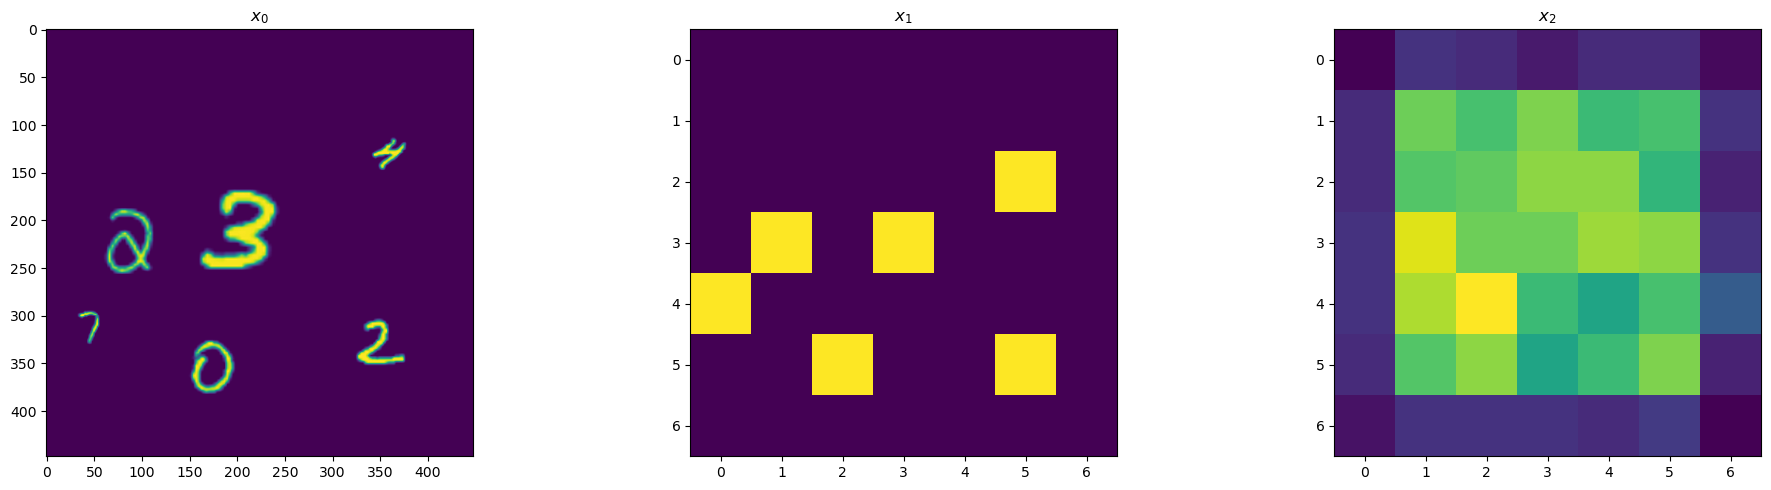

Loss at 1/10 is: 127.27748095800006


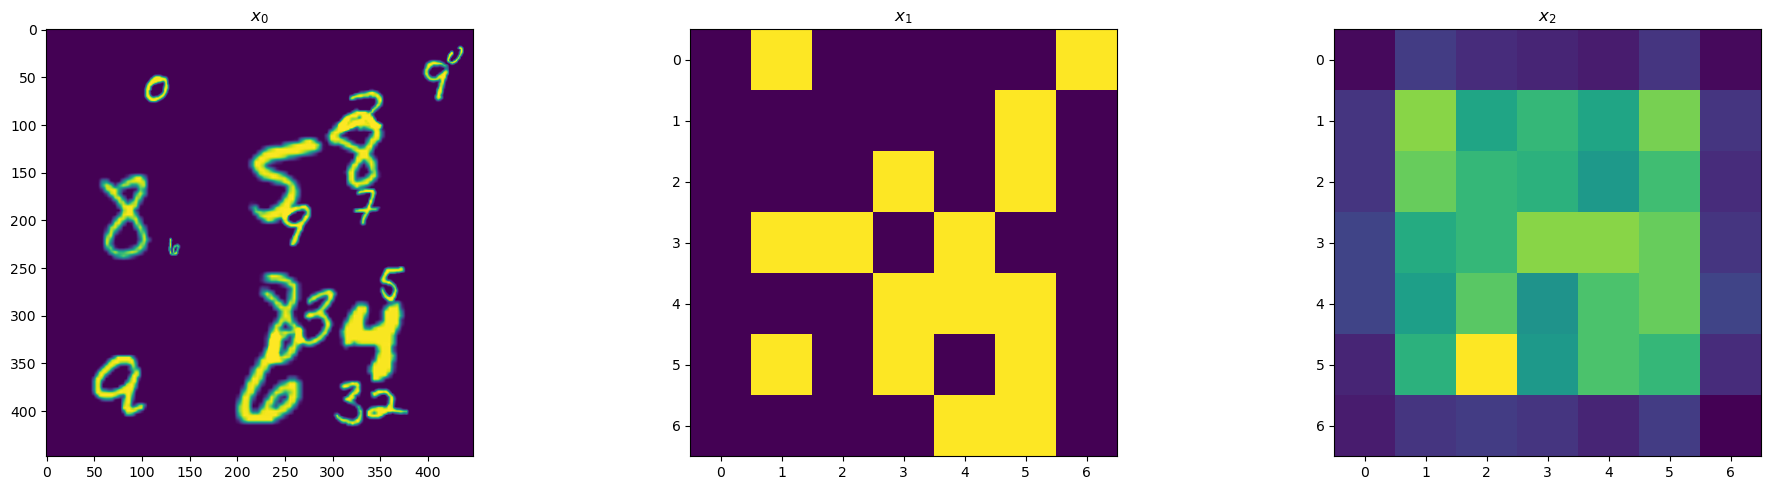

Loss at 2/10 is: 123.81293697458095


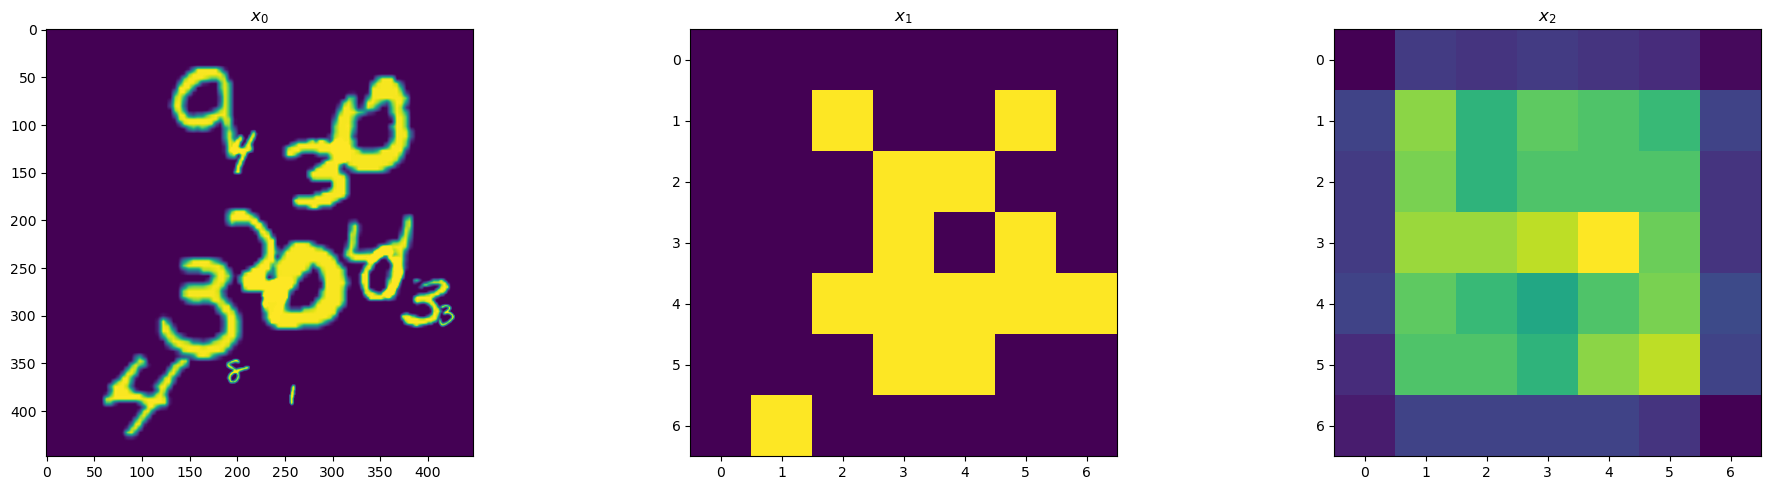

Loss at 3/10 is: 122.11971735575843


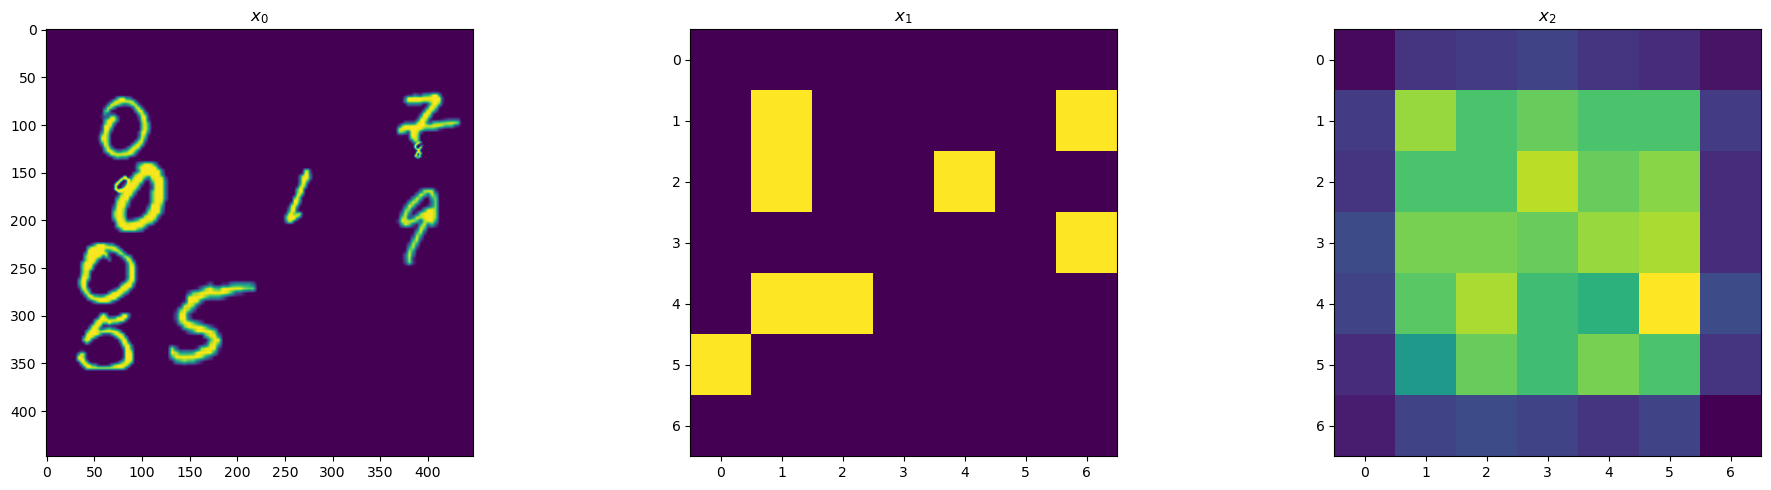

Loss at 4/10 is: 121.06528585524786


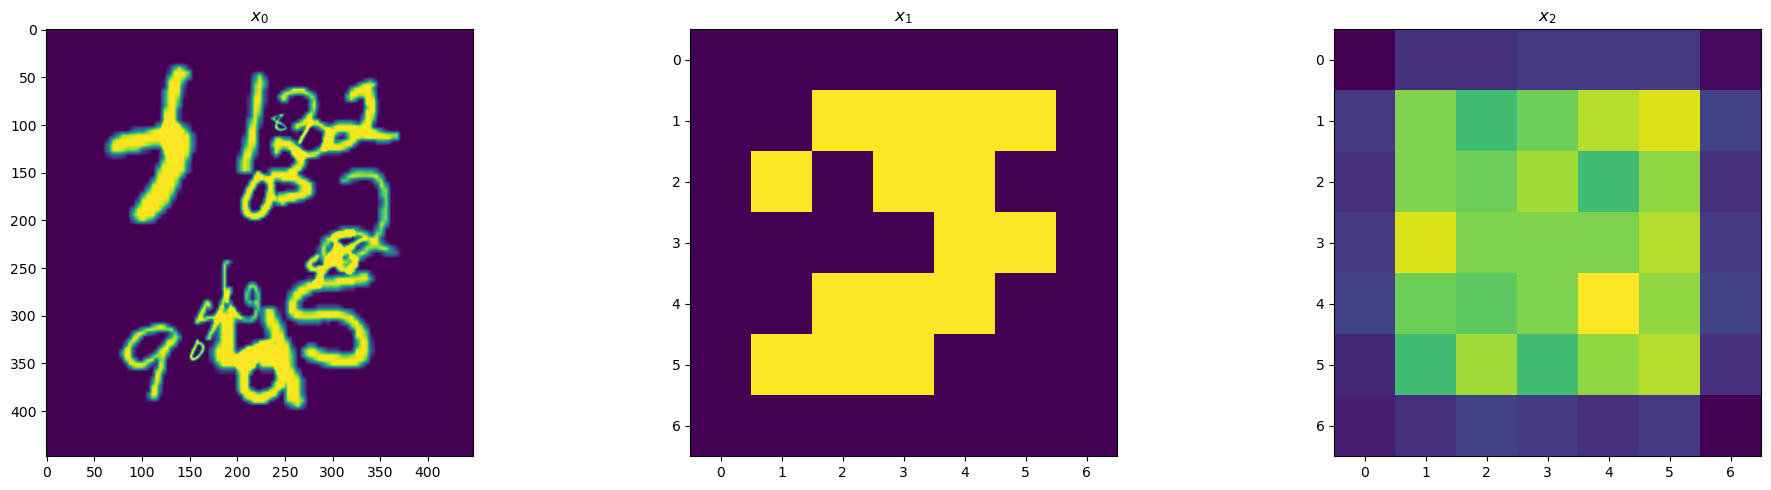

Loss at 5/10 is: 120.37814957754952


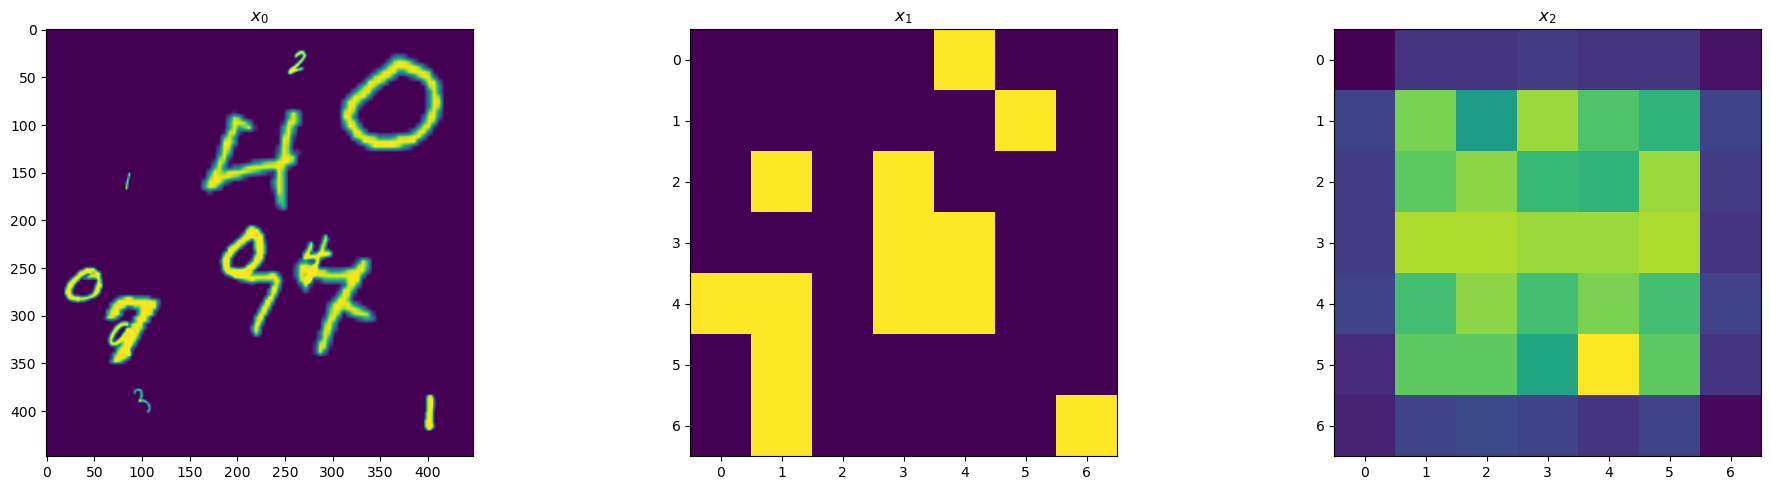

Loss at 6/10 is: 119.86142921015248


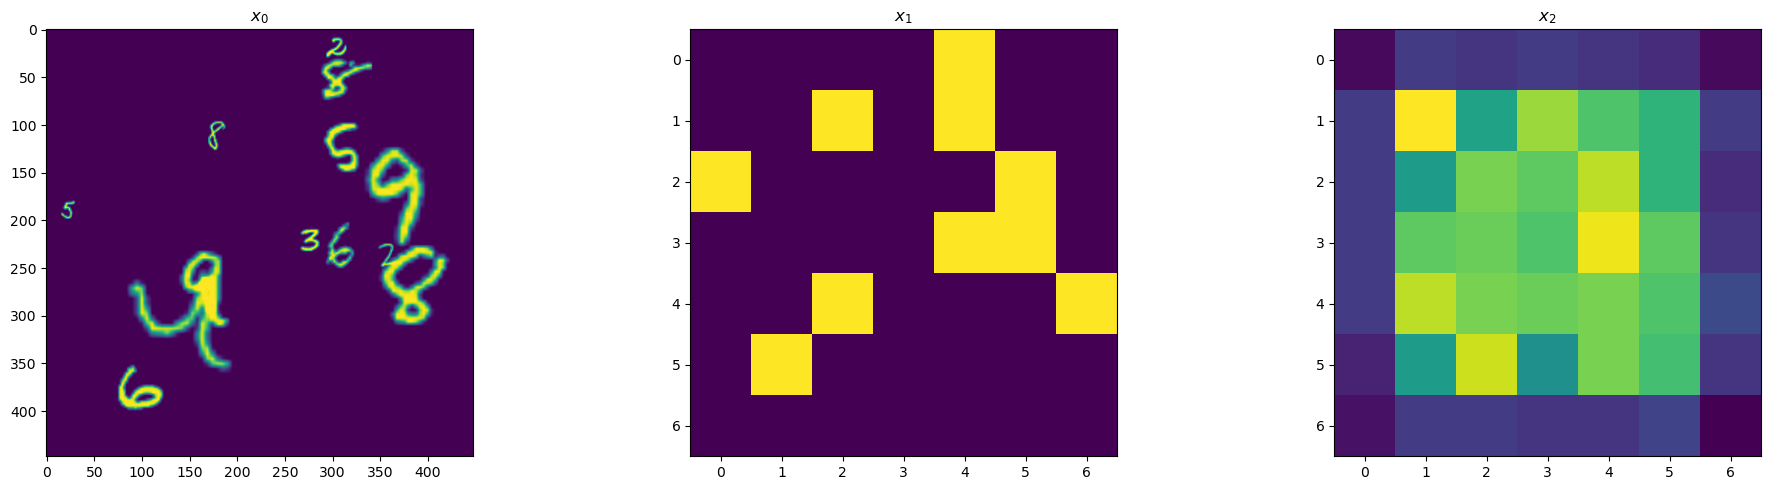

Loss at 7/10 is: 119.47949609302339


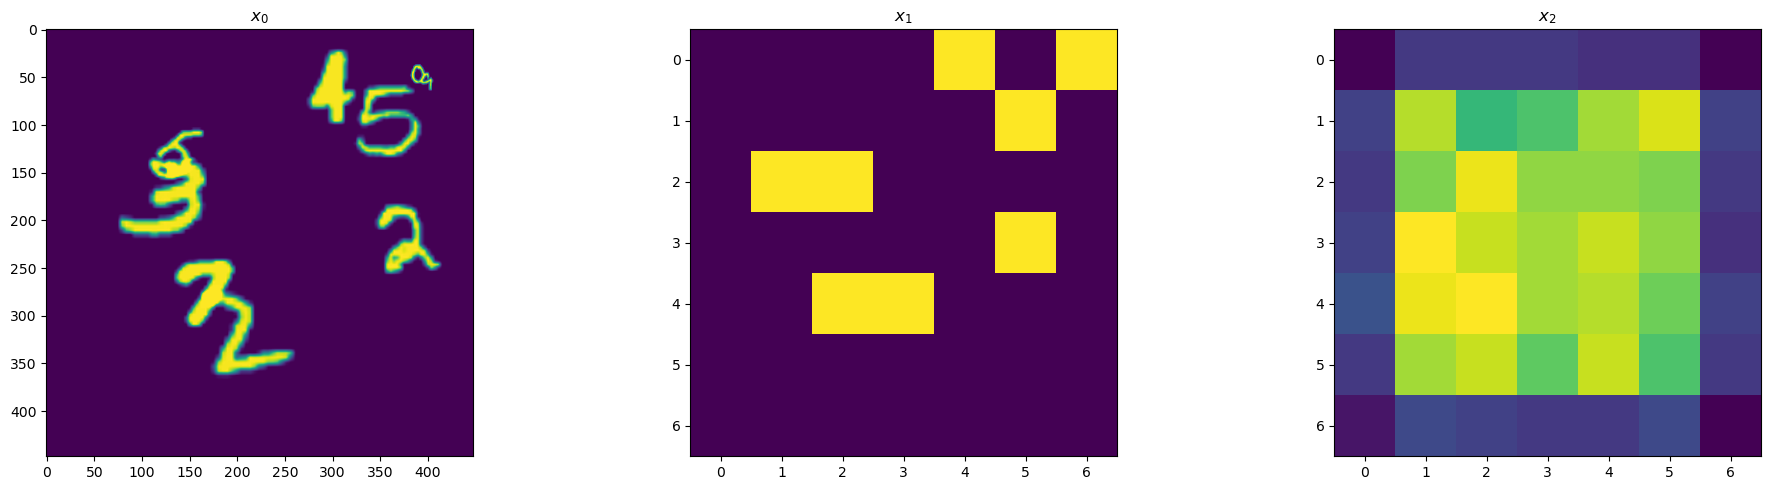

Loss at 8/10 is: 119.18368502689206


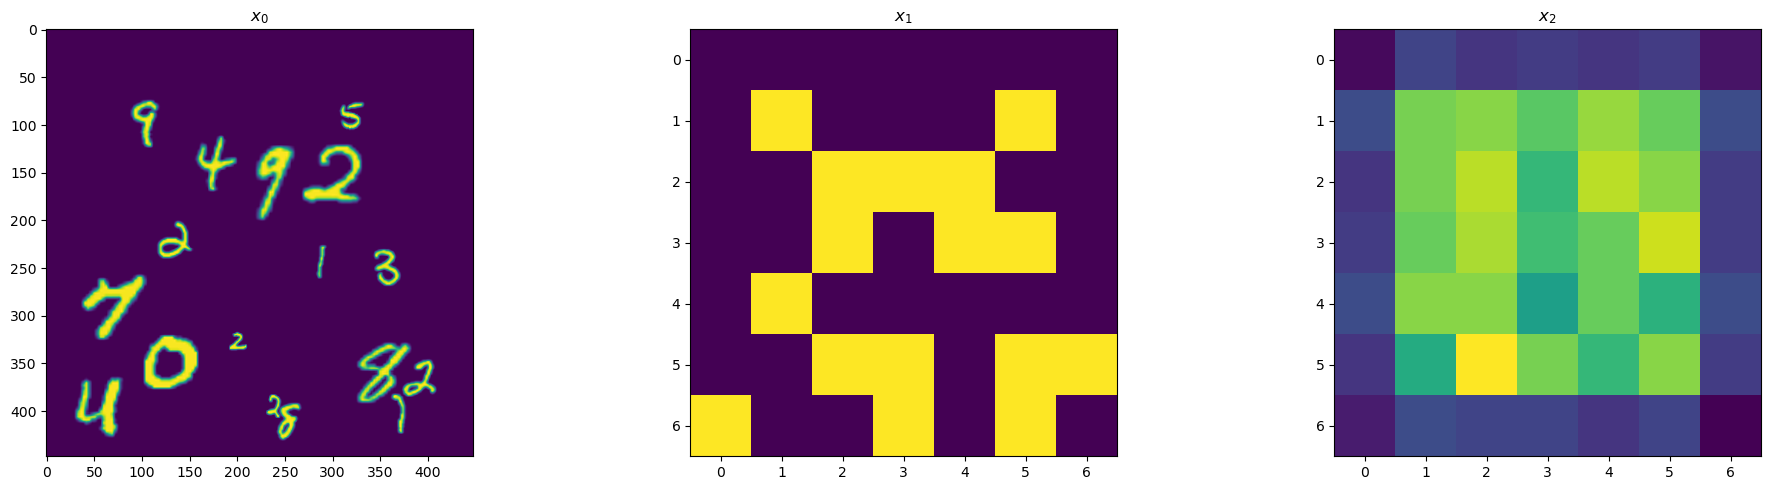

Loss at 9/10 is: 118.9348455096048


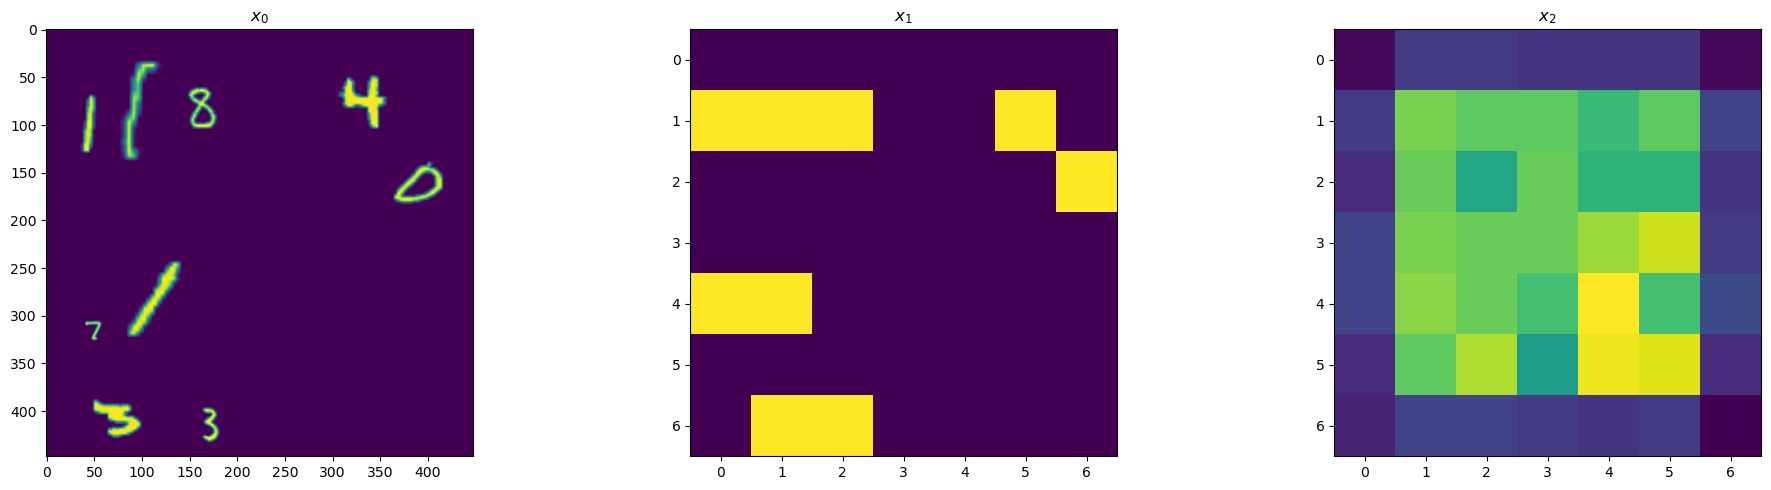

In [3]:
from model import YOLOv1
import torchvision.transforms as T
from torch import nn
from torch import optim
import numpy as np
from utils import plot_images, clean_gpu


# to plot the loss
loss_history = []

# clean gpu before wathever
clean_gpu()

# model
model = YOLOv1(S=7, depth=1).to(device)
model.train()

# optimizatino algorithm
mse = nn.MSELoss(reduction='sum')
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#training loop
EPOCHS = 10
for epoch in range(EPOCHS):
    n_break = 0
    model.train()
    for idx, data in enumerate(train_loader):
        # get the inputs
        img, target = data
        img, target = img.to(device), target['one_obj'].to(device)

        # zero the parameters
        optimizer.zero_grad()
        
        # forward
        prediction = model(img)
        predict_confidence = torch.sigmoid(prediction[...,0])
        target_confidence = target.squeeze()

        # backward + optimize
        loss = mse(target_confidence, predict_confidence)
        loss.backward()
        optimizer.step()


        loss_history.append(loss.detach().item())

    print(f'Loss at {epoch}/{EPOCHS} is: {np.average(np.array(loss_history))}')


    for idx, data in enumerate(train_loader):

        # get the inputs
        img, target = data
        img, target = img.to(device), target['one_obj'].to(device)

        # forward
        prediction = model(img)
        predict_confidence = torch.sigmoid(prediction[...,0])
        target_confidence = target.squeeze()

        img2show = img.detach()[0,...].cpu()
        target2show = target_confidence.detach()[0,...].cpu()
        predict2show = predict_confidence.detach()[0,...].cpu()
        
        plot_images([img2show, target2show, predict2show], title='awd')

        if idx == n_break:
            break
        